In [8]:
import os
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import MeanIoU
from tensorflow import keras
from sspfpn import SSPFPN
import prepareVOC12 as voc

In [2]:
# os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [3]:
class_dict = voc.class_dict
data_dir = "./VOC12/test"
labels_dir = "./VOC12/test_label"

x, y = voc.load_data(data_dir, labels_dir)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=42)

print(x_train.shape)
print(x_val.shape)    
print(y_train.shape)
print(y_val.shape)

(480, 224, 224, 3)
(120, 224, 224, 3)
(480, 224, 224, 3)
(120, 224, 224, 3)


In [4]:
# convert labels to one_hot_maps

y_train_onehot = []
y_val_onehot = []

for label_map in y_train:
    one_hot_map = voc.label_to_onehot(label_map, class_dict)
    y_train_onehot.append(one_hot_map)

for label_map in y_val:
    one_hot_map = voc.label_to_onehot(label_map, class_dict)
    y_val_onehot.append(one_hot_map)

y_train_onehot = np.array(y_train_onehot)
y_val_onehot = np.array(y_val_onehot)

Text(0.5, 1.0, 'Converted Label Map')

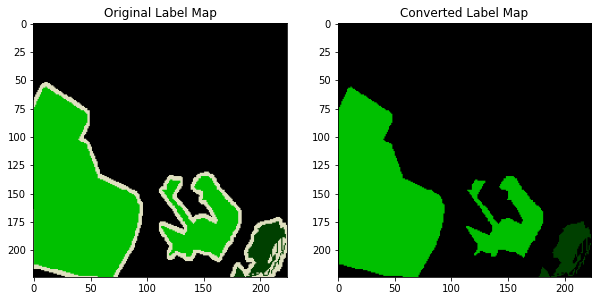

In [5]:
index = 3
original_label_map = y_val[index]
one_hot_map = y_val_onehot[index]
converted_label_map = voc.onehot_to_label(one_hot_map, class_dict)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(original_label_map)
axs[0].set_title('Original Label Map')
axs[1].imshow(converted_label_map)
axs[1].set_title('Converted Label Map')

In [9]:
# Create and train the model
opt = SGD(learning_rate=2.5e-5, momentum=0.9, decay=5e-4)
input_shape = (224, 224, 3)
model = SSPFPN(input_shape)

# Compile the model
model.compile(optimizer="adam", loss='binary_crossentropy', metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), MeanIoU(num_classes=21)])

In [10]:
history = model.fit(x_train, y_train_onehot, epochs= 5, batch_size= 5, validation_data=(x_val, y_val_onehot))

# from keras.preprocessing.image import ImageDataGenerator
    
# # Configure the data augmentation
# datagen = ImageDataGenerator(
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     fill_mode='nearest'
# )

# # Fit the generator to the training data
# datagen.fit(x_train)

# # Train the model with the augmented data
# model.fit(datagen.flow(x_train, y_train_onehot, batch_size=5),
#           epochs=3,
#           validation_data=(x_val, y_val_onehot))

Epoch 1/5
96/96 [==============================] - 29s 285ms/step - loss: 0.1179 - accuracy: 0.7128 - precision: 0.6798 - recall: 0.6141 - mean_io_u_1: 0.4775 - val_loss: 0.0781 - val_accuracy: 0.7589 - val_precision: 0.8095 - val_recall: 0.6850 - val_mean_io_u_1: 0.4774
Epoch 2/5
96/96 [==============================] - 27s 277ms/step - loss: 0.0766 - accuracy: 0.7433 - precision: 0.8234 - recall: 0.6408 - mean_io_u_1: 0.4775 - val_loss: 0.0728 - val_accuracy: 0.7464 - val_precision: 0.8898 - val_recall: 0.5994 - val_mean_io_u_1: 0.4774
Epoch 3/5
96/96 [==============================] - 27s 278ms/step - loss: 0.0710 - accuracy: 0.7538 - precision: 0.8420 - recall: 0.6491 - mean_io_u_1: 0.4775 - val_loss: 0.0758 - val_accuracy: 0.7170 - val_precision: 0.8000 - val_recall: 0.6379 - val_mean_io_u_1: 0.4774
Epoch 4/5
96/96 [==============================] - 27s 279ms/step - loss: 0.0699 - accuracy: 0.7556 - precision: 0.8351 - recall: 0.6530 - mean_io_u_1: 0.4775 - val_loss: 0.0684 - val_

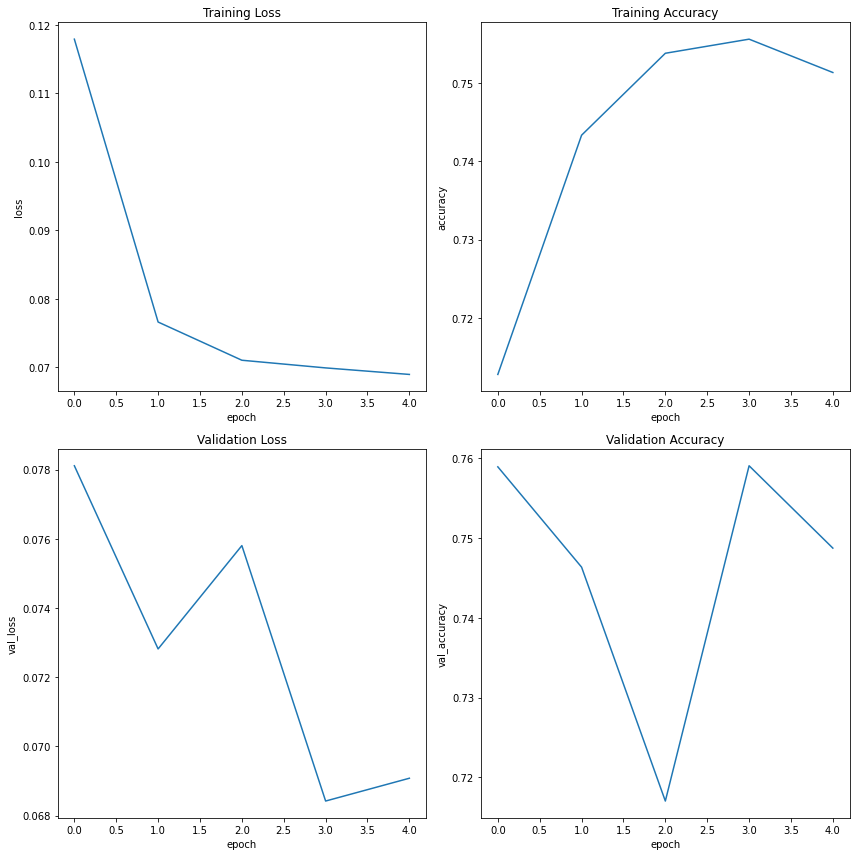

In [11]:
fig, axes = plt.subplots(2, 2, figsize=(12, 12))

# Training Loss
axes[0, 0].plot(history.history["loss"])
axes[0, 0].set_title("Training Loss")
axes[0, 0].set_ylabel("loss")
axes[0, 0].set_xlabel("epoch")

# Training Accuracy
axes[0, 1].plot(history.history["accuracy"])
axes[0, 1].set_title("Training Accuracy")
axes[0, 1].set_ylabel("accuracy")
axes[0, 1].set_xlabel("epoch")

# Validation Loss
axes[1, 0].plot(history.history["val_loss"])
axes[1, 0].set_title("Validation Loss")
axes[1, 0].set_ylabel("val_loss")
axes[1, 0].set_xlabel("epoch")

# Validation Accuracy
axes[1, 1].plot(history.history["val_accuracy"])
axes[1, 1].set_title("Validation Accuracy")
axes[1, 1].set_ylabel("val_accuracy")
axes[1, 1].set_xlabel("epoch")

plt.tight_layout()
plt.show()

In [12]:
with tf.device('/CPU:0'):
    history = model.predict(x_val, batch_size=5)

# history = model.predict(x_train)

24/24 [==============================] - 21s 863ms/step


In [13]:
y_pred = []
for onehot in history:
    y_pred.append(voc.onehot_to_label(onehot, voc.class_dict))

y_pred = np.array(y_pred).astype('uint8')

In [14]:
def pixel_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / np.prod(y_true.shape)

def mean_accuracy(y_true, y_pred, num_classes):
    class_accuracies = np.zeros(num_classes)
    for i in range(num_classes):
        mask = y_true == i
        if np.sum(mask) > 0:
            class_accuracies[i] = np.sum((y_pred[mask] == y_true[mask])) / np.sum(mask)
    return np.mean(class_accuracies)

def mean_iou(y_true, y_pred, num_classes):
    class_ious = np.zeros(num_classes)
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        if union > 0:
            class_ious[i] = intersection / union
    return np.nanmean(class_ious)

def frequency_weighted_iou(y_true, y_pred, num_classes):
    total_pixels = 0
    weighted_iou_sum = 0
    for i in range(num_classes):
        intersection = np.sum((y_true == i) & (y_pred == i))
        union = np.sum((y_true == i) | (y_pred == i))
        total_pixels += np.sum(y_true == i)
        if np.sum(y_true == i) > 0:
            weighted_iou_sum += (np.sum(y_true == i) * (intersection / union))
    return weighted_iou_sum / total_pixels

In [15]:

pa = pixel_accuracy(y_val, y_pred)
ma = mean_accuracy(y_val, y_pred, num_classes=21)
miou = mean_iou(y_val, y_pred, num_classes=21)
fwiou = frequency_weighted_iou(y_val, y_pred, num_classes=21)

print(f"Pixel Accuracy: {pa:.4f}")
print(f"Mean Accuracy: {ma:.4f}")
print(f"Mean IoU: {miou:.4f}")
print(f"Frequency Weighted IoU: {fwiou:.4f}")

Pixel Accuracy: 0.7834
Mean Accuracy: 0.0440
Mean IoU: 0.0381
Frequency Weighted IoU: 0.7992


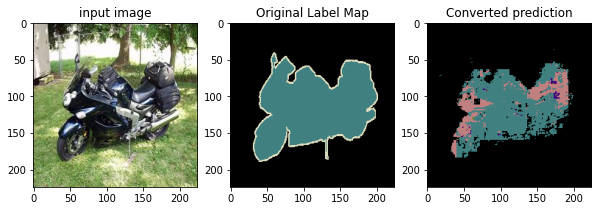

In [96]:
index = 75
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(x_val[index])
axs[0].set_title('input image')
axs[1].imshow(y_val[index])
axs[1].set_title('Original Label Map')
axs[2].imshow(y_pred[index])
axs[2].set_title('Converted prediction')

plt.show()